# Pytorch

---

## Library

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassConfusionMatrix

import numpy as np
import seaborn as sns
import time

import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Load data
We load data which is preprocessed before.

In [6]:
import pickle
with open('../data/preprocessed_data.pkl', 'rb') as f:
    X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(f)

Load data to pytorch :<br>
In PyTorch, data preparation involves converting datasets into `torch.Tensor` format for compatibility with the framework. After this, `Dataset` objects are created to pair inputs and labels, followed by `DataLoader` to handle batching, shuffling, and efficient data loading. This process ensures seamless and organized feeding of data into the model during training, validation, and testing.

In [7]:
# transfer to  tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.argmax(axis=1), dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.argmax(axis=1), dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.argmax(axis=1), dtype=torch.long)

# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Train Loader Batches: {len(train_loader)}")
print(f"Validation Loader Batches: {len(val_loader)}")
print(f"Test Loader Batches: {len(test_loader)}")

Train Loader Batches: 313
Validation Loader Batches: 79
Test Loader Batches: 79


# Model design
We used `Multi-Layer Perceptron (MLP)` architecture designed for multi-class classification tasks. Our model includes 2 hidden layer with sizes [256, 128], each followed by batch normalization and ReLU activation. The final output layer has 10 neurons for classification. Then, we used `nn.Sequential` to define the architecture for simplicity, and the model is configured to run on GPU if available.<br>
We will construct the model with the following architecture:
- Hidden Layers: Two layers with 256 and 128 neurons, respectively.
- Activation Function: ReLU (Rectified Linear Unit).
- Optimizer: Adam.
- Batch Size: 128.
- Learning Rate: Initial value of 0.001, decreasing by 0.1% every 10 epochs.
- Maximum Iterations: 200.
- Early Stopping: Stop training if the loss does not improve within 10 epochs.

In [8]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_prob=0.5):
        super(MLPClassifier, self).__init__()
        
        # Define layers
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            # nn.BatchNorm1d(hidden_sizes[0]),
            nn.ReLU(),
            # nn.Dropout(p=dropout_prob),
            
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            # nn.BatchNorm1d(hidden_sizes[1]),
            nn.ReLU(),
            # nn.Dropout(p=dropout_prob),
        
            nn.Linear(hidden_sizes[1], output_size)
        )

    def forward(self, x):
        return self.model(x)

# model parameters
input_size = X_train.shape[1]
hidden_sizes = [256, 128]
output_size = 10  # 10 classes - CIFAR-10

# set device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the model
model = MLPClassifier(input_size, hidden_sizes, output_size).to(device)
print(model)
print(f"Model is on device: {next(model.parameters()).device}")


MLPClassifier(
  (model): Sequential(
    (0): Linear(in_features=3072, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)
Model is on device: cuda:0


# Selecting Loss Function and Optimizer
We use `CrossEntropyLoss` as our loss function. For optimization, we chose the `Adam` optimizer with a learning rate of 0.001, ensuring efficient and adaptive gradient updates. Then, we included a `StepLR` scheduler, which reduces the learning rate by a factor of 0.1 every 10 epochs to improve convergence during training.

In [9]:
# cross-entropy loss
criterion = nn.CrossEntropyLoss()

# optimize
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
print(f"Loss Function: {criterion}")
print(f"Optimizer: {optimizer}")

Loss Function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0
)


# Model Training
We implemented a `Neural Network` with an `MLP` architecture, performing forward passes, weight updates, and backpropagation during training. To ensure efficient training, we integrated `Early Stopping` . This process included loss and accuracy for both training and validation, is logged for each epoch.

In [10]:
# Early Stopping 
patience = 10
min_delta = 0.001  # min value improve
best_loss = float('inf')
no_improve_epochs = 0

num_epochs = 200

# Mark the start time
start_time = time.time()

for epoch in range(num_epochs):
	model.train() # train mode
	train_loss = 0.0 

	for i, (inputs, labels) in enumerate(train_loader):
		inputs, labels = inputs.to(device), labels.to(device)

		# Forward pass
		outputs = model(inputs)
		loss = criterion(outputs, labels)

		# Backpropagation
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		train_loss += loss.item()
	scheduler.step()

	# Evaluate on validation
	model.eval() # evalution mode
	val_loss = 0.0
	correct = 0
	total = 0

	with torch.no_grad():
		for inputs, labels in val_loader:
			inputs, labels = inputs.to(device), labels.to(device)

			outputs = model(inputs)
			loss = criterion(outputs, labels)
			val_loss += loss.item()

			_, predicted = torch.max(outputs, 1)
			total += labels.size(0)
			correct += (predicted == labels).sum().item()

	val_accuracy = 100 * correct / total
	avg_val_loss = val_loss / len(val_loader)

	print(f"Epoch {epoch + 1}/{num_epochs}, "
		  f"Train Loss: {train_loss / len(train_loader):.4f}, "
		  f"Validation Loss: {avg_val_loss:.4f}, "
		  f"Validation Accuracy: {val_accuracy:.2f}%")

	# Early Stopping logic
	if avg_val_loss < best_loss - min_delta:
		best_loss = avg_val_loss
		no_improve_epochs = 0
		print("Validation loss improved. Saving model...")
		torch.save(model.state_dict(), "best_model.pth") 
	else:
		no_improve_epochs += 1
		print(f"No improvement for {no_improve_epochs} epochs.")

	if no_improve_epochs >= patience:
		print("Early stopping triggered.")
		break
# Mark the end time
end_time = time.time()

Epoch 1/200, Train Loss: 1.8920, Validation Loss: 1.7676, Validation Accuracy: 37.13%
Validation loss improved. Saving model...
Epoch 2/200, Train Loss: 1.7053, Validation Loss: 1.6948, Validation Accuracy: 39.72%
Validation loss improved. Saving model...
Epoch 3/200, Train Loss: 1.6148, Validation Loss: 1.6015, Validation Accuracy: 42.99%
Validation loss improved. Saving model...
Epoch 4/200, Train Loss: 1.5592, Validation Loss: 1.5948, Validation Accuracy: 44.09%
Validation loss improved. Saving model...
Epoch 5/200, Train Loss: 1.5213, Validation Loss: 1.5760, Validation Accuracy: 44.14%
Validation loss improved. Saving model...
Epoch 6/200, Train Loss: 1.4798, Validation Loss: 1.5697, Validation Accuracy: 44.85%
Validation loss improved. Saving model...
Epoch 7/200, Train Loss: 1.4517, Validation Loss: 1.5169, Validation Accuracy: 46.37%
Validation loss improved. Saving model...
Epoch 8/200, Train Loss: 1.4266, Validation Loss: 1.4980, Validation Accuracy: 47.21%
Validation loss im

In [11]:
# Calculate the training time
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

Training time: 42.92 seconds


# Model Evaluation

Accuracy: 0.5179
Precision: 0.5124
Recall: 0.5179
F1-Score: 0.5136


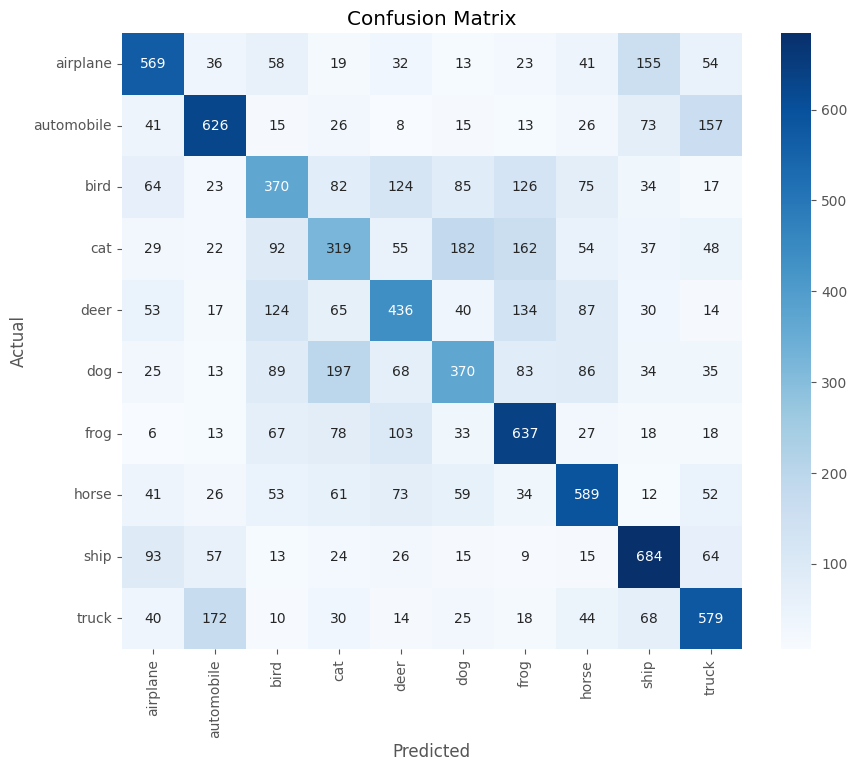

In [12]:
# class in CIFAR-10 dataset
num_classes = 10

# metric
accuracy = MulticlassAccuracy(num_classes=num_classes, average="macro")
precision = MulticlassPrecision(num_classes=num_classes, average="macro")
recall = MulticlassRecall(num_classes=num_classes, average="macro")
f1 = MulticlassF1Score(num_classes=num_classes, average="macro")
conf_matrix = MulticlassConfusionMatrix(num_classes=num_classes)

# load data from test loader
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # max predict value
        # covert to numpy
        all_preds.extend(predicted.cpu().numpy())  
        all_labels.extend(labels.cpu().numpy()) 
# convert to tensor
all_preds = torch.tensor(all_preds)
all_labels = torch.tensor(all_labels)

# Evaluate
acc = accuracy(all_preds, all_labels)
prec = precision(all_preds, all_labels)
rec = recall(all_preds, all_labels)
f1_score = f1(all_preds, all_labels)
conf_matrix_result = conf_matrix(all_preds, all_labels)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1_score:.4f}")

# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_result.numpy(), annot=True, fmt="d", cmap="Blues", xticklabels=[
    "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"
], yticklabels=[
    "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"
])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Further Usage

In [13]:
# torch.save(model.state_dict(), "../models/pytorch_model.pth")  # weight
torch.save(model, "../models/pytorch_model.pth")  # model

In [14]:
# load model
loaded_model = torch.load("../models/pytorch_model.pth", weights_only=False)
loaded_model.eval()


MLPClassifier(
  (model): Sequential(
    (0): Linear(in_features=3072, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

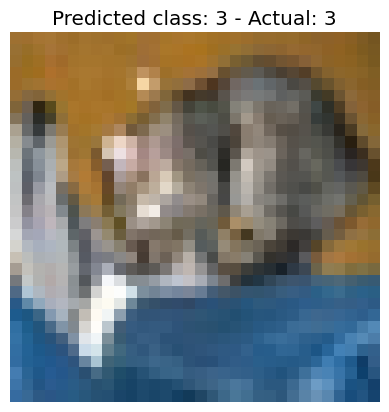

In [15]:
single_image = X_test[0]  # fist image in test
single_image = torch.tensor(single_image).unsqueeze(0).to(device) 
output = loaded_model(single_image)
predicted_class = torch.argmax(output, 1).item()

single_image_cpu = single_image.squeeze().cpu().numpy().reshape(32, 32, 3) 

# show image
y_test = np.argmax(y_test, axis=1) 
plt.imshow(single_image_cpu, cmap='gray') 
plt.title(f"Predicted class: {predicted_class} - Actual: {y_test[0]}")
plt.axis('off')
plt.show()


GPU usage

In [16]:
import GPUtil as GPU

GPUs = GPU.getGPUs()
for gpu in GPUs:
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

GPU RAM Free: 3577MB | Used: 388MB | Util   9% | Total 4096MB
